In [1]:
import numpy as np 
import pandas as pd 
import torch
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import evaluate, train_and_eval, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 
DEC_DROPOUT = 0  
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 10 
LR = 0.00015 
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
if NETWORK_TYPE == 'rnn': 
    EXPERIMENT_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    EXPERIMENT_NAME = '{}-cnn'.format(SRC_LANG)
MODEL_NAME = '{}-{}'.format(EXPERIMENT_NAME, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [9]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=True, print_attn=True, inspect_samples=2)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.27, Train BLEU: 0.00, Val BLEU: 0.05, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: " trước_khi tôi chết , tôi muốn được hát cho
Reference: &quot; before i die , i want to sing
Model: <SOS> and and and the the the the leftovers edits
Attention Weights: tensor([[0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.0994],
        [0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.0994],
        [0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.0994],
        [0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.0994],
        [0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.0994],
        [0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.0994],
        [0.1003, 0.1006, 0.1004, 0.0999, 0.1002, 0.1001, 0.0999, 0.0997, 0.0995,
         0.

Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.08, Train BLEU: 0.00, Val BLEU: 1.09, Minutes Elapsed: 10.24
Sampling from val predictions...
Source: không có ngày nào mà tôi không nghĩ về những
Reference: there is not a day that goes by that
Model: <SOS> so i , , , , , , ,
Attention Weights: tensor([[4.1895e-04, 1.9566e-03, 1.3848e-02, 6.9876e-02, 1.6222e-01, 2.1904e-01,
         2.1429e-01, 1.7136e-01, 1.0192e-01, 4.5056e-02],
        [4.9025e-04, 2.7970e-03, 1.9008e-02, 8.6537e-02, 1.7913e-01, 2.2559e-01,
         2.1030e-01, 1.6227e-01, 8.5675e-02, 2.8200e-02],
        [4.9962e-06, 3.8118e-05, 3.6232e-04, 4.5243e-03, 1.9264e-02, 4.3134e-02,
         4.8139e-02, 6.2703e-02, 1.5846e-01, 6.6337e-01],
        [4.8725e-06, 1.5331e-05, 7.2079e-05, 5.7044e-04, 2.5014e-03, 6.5581e-03,
         7.8418e-03, 1.1418e-02, 4.6065e-02, 9.2495e-01],
        [1.8995e-05, 4.5451e-05, 1.5927e-04, 8.3482e-04, 2.9062e-03, 6.8550e-03,
         8.2354e-03, 1.1725e-02, 4.2915e-02, 9.2630e-01],
        [4.9109e

Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.64, Train BLEU: 0.00, Val BLEU: 2.87, Minutes Elapsed: 21.52
Sampling from val predictions...
Source: anh ta muốn biết mọi thứ về gia_đình tôi và
Reference: he wanted to know everything about my family and
Model: <SOS> but you you you you to to , the
Attention Weights: tensor([[3.1109e-04, 1.9979e-01, 3.8555e-01, 4.0228e-01, 1.1098e-02, 5.9669e-04,
         1.2836e-04, 9.8545e-05, 1.0473e-04, 4.7753e-05],
        [4.2920e-03, 3.6434e-01, 4.3543e-01, 1.9047e-01, 4.6220e-03, 3.4344e-04,
         1.2107e-04, 1.0986e-04, 1.5247e-04, 1.1085e-04],
        [2.1252e-03, 1.9112e-01, 5.0596e-01, 2.9625e-01, 4.2569e-03, 1.2129e-04,
         2.7962e-05, 3.0423e-05, 7.1564e-05, 4.0404e-05],
        [1.7459e-04, 2.3621e-03, 2.6055e-02, 7.6073e-01, 2.0352e-01, 5.8913e-03,
         3.8653e-04, 2.6143e-04, 5.1153e-04, 1.1170e-04],
        [1.7504e-05, 8.1017e-05, 6.7531e-04, 6.5596e-02, 5.2210e-01, 2.6483e-01,
         5.4118e-02, 3.3394e-02, 5.2769e-02, 6.423

Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.28, Train BLEU: 0.00, Val BLEU: 5.45, Minutes Elapsed: 32.51
Sampling from val predictions...
Source: vậy điều gì đã xảy_ra ? <EOS> <PAD> <PAD> <PAD>
Reference: so what happened ? <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> what what what do ? ? ? ? ?
Attention Weights: tensor([[0.5941, 0.3611, 0.0336, 0.0027, 0.0016, 0.0065, 0.0005, 0.0000, 0.0000,
         0.0000],
        [0.0799, 0.7678, 0.1463, 0.0038, 0.0007, 0.0013, 0.0002, 0.0000, 0.0000,
         0.0000],
        [0.0009, 0.0934, 0.8466, 0.0460, 0.0042, 0.0081, 0.0008, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0018, 0.5157, 0.3615, 0.0400, 0.0789, 0.0022, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0052, 0.1497, 0.1688, 0.6440, 0.0323, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0002, 0.0105, 0.0562, 0.7998, 0.1333, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0002, 0.0060, 0.0373, 0.7568, 0.1997, 0.0000, 0.0000,
         0.0

Epoch: 0.96, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.89, Minutes Elapsed: 43.30
Sampling from val predictions...
Source: trên hết , <UNK> bị bệnh lao , nhưng vẫn
Reference: on top of that , <UNK> has tuberculosis ,
Model: <SOS> in , , , , , , , ,
Attention Weights: tensor([[5.0448e-01, 3.3756e-01, 7.2861e-02, 1.8516e-02, 1.3856e-02, 8.1272e-03,
         7.5959e-03, 1.3434e-02, 6.5314e-03, 1.7042e-02],
        [2.1620e-01, 6.1080e-01, 1.3397e-01, 2.6025e-02, 7.2920e-03, 2.6447e-03,
         1.1039e-03, 8.1176e-04, 5.8066e-04, 5.6614e-04],
        [1.1313e-02, 1.7110e-01, 4.9989e-01, 2.5816e-01, 4.9426e-02, 7.7674e-03,
         1.1508e-03, 4.7936e-04, 3.8641e-04, 3.2345e-04],
        [7.3994e-05, 3.4393e-03, 1.8018e-01, 5.7542e-01, 1.9884e-01, 3.5656e-02,
         3.8139e-03, 1.2295e-03, 7.8800e-04, 5.5332e-04],
        [1.6353e-06, 9.5483e-05, 1.1623e-02, 3.9134e-01, 4.6819e-01, 1.1666e-01,
         9.1985e-03, 1.5871e-03, 8.4743e-04, 4.5152e-04],
        [1.1913

Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 7.27, Minutes Elapsed: 45.20
Sampling from val predictions...
Source: ở trường , chúng_tôi dành rất nhiều thời_gian để học
Reference: in school , we spent a lot of time
Model: <SOS> in , , we we a to of to
Attention Weights: tensor([[2.1911e-01, 4.3436e-01, 3.0398e-01, 4.1566e-02, 2.9119e-04, 1.8882e-04,
         4.1314e-05, 2.2313e-05, 2.9036e-04, 1.5379e-04],
        [6.2296e-02, 2.7693e-01, 4.3900e-01, 1.8985e-01, 2.0682e-02, 6.3884e-03,
         1.6057e-03, 6.5357e-04, 1.6536e-03, 9.4328e-04],
        [5.2712e-03, 2.6712e-02, 2.5174e-01, 6.5273e-01, 5.6282e-02, 6.2013e-03,
         5.2060e-04, 1.1413e-04, 3.1005e-04, 1.1416e-04],
        [8.7959e-04, 6.8886e-03, 2.7033e-01, 6.6883e-01, 4.7484e-02, 5.0833e-03,
         2.3292e-04, 3.0168e-05, 1.9868e-04, 4.5547e-05],
        [7.2143e-05, 4.0986e-04, 2.2137e-02, 5.0913e-01, 4.1142e-01, 5.4652e-02,
         1.8350e-03, 8.2324e-05, 2.2915e-04, 3.5902e-05],
     

Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.87, Train BLEU: 0.00, Val BLEU: 8.79, Minutes Elapsed: 56.03
Sampling from val predictions...
Source: ít_hơn một tháng rồi , ông và con_gái ông đang
Reference: less than a month ago , he and his
Model: <SOS> there a , , , and and and and
Attention Weights: tensor([[9.6667e-01, 3.2346e-02, 6.5517e-04, 2.3073e-04, 3.3588e-05, 1.7924e-05,
         2.3568e-05, 2.0977e-06, 1.2134e-05, 7.1022e-06],
        [4.3897e-01, 4.8109e-01, 7.3699e-02, 5.8290e-03, 2.0132e-04, 1.0833e-04,
         7.3203e-05, 6.9691e-06, 1.3156e-05, 6.0089e-06],
        [1.0274e-02, 6.0512e-02, 3.9560e-01, 4.9466e-01, 2.6222e-02, 1.0718e-02,
         1.7908e-03, 6.7190e-05, 1.3160e-04, 2.2971e-05],
        [3.1197e-04, 3.0582e-03, 5.9663e-02, 6.5807e-01, 1.5870e-01, 9.9901e-02,
         1.7830e-02, 7.4837e-04, 1.4943e-03, 2.2813e-04],
        [3.8427e-05, 3.8285e-04, 7.4162e-03, 1.4312e-01, 2.2126e-01, 5.0135e-01,
         1.0982e-01, 6.5087e-03, 8.7778e-03, 1.3164e-03],
     

Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.75, Train BLEU: 0.00, Val BLEU: 9.24, Minutes Elapsed: 67.40
Sampling from val predictions...
Source: tôi muốn nó được biết đến bởi công_chúng . <EOS>
Reference: i want to make them public . <EOS> <PAD>
Model: <SOS> i want to to to . . . <EOS>
Attention Weights: tensor([[9.9420e-01, 5.7906e-03, 2.2460e-06, 1.4440e-06, 7.4632e-07, 1.7974e-07,
         6.8389e-08, 4.1479e-08, 6.6968e-08, 2.5515e-08],
        [4.1085e-03, 9.9522e-01, 5.1466e-04, 1.2767e-04, 2.2893e-05, 2.7911e-06,
         9.3116e-07, 2.2692e-07, 1.7056e-07, 1.2627e-07],
        [2.2006e-03, 7.9614e-01, 1.3934e-01, 4.8737e-02, 1.2652e-02, 8.1392e-04,
         9.8372e-05, 8.6334e-06, 3.4152e-06, 1.5942e-06],
        [1.0529e-03, 7.7154e-02, 1.7503e-01, 3.6277e-01, 3.3914e-01, 3.9575e-02,
         4.9292e-03, 2.7277e-04, 5.8295e-05, 2.0106e-05],
        [9.1510e-06, 1.0690e-03, 1.8939e-02, 1.3235e-01, 4.9674e-01, 2.5234e-01,
         9.3601e-02, 4.4905e-03, 3.8161e-04, 7.4998e-05],

Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.55, Train BLEU: 0.00, Val BLEU: 10.39, Minutes Elapsed: 90.76
Sampling from val predictions...
Source: bạn sẽ kết_luận được gì từ những mẫu này ?
Reference: what are you going to get out of those
Model: <SOS> do you you you to this this ? ?
Attention Weights: tensor([[9.8774e-01, 1.0317e-02, 2.0967e-04, 4.0014e-04, 4.5431e-04, 1.2998e-04,
         4.1852e-05, 1.3556e-04, 2.5601e-04, 3.1591e-04],
        [1.2853e-01, 8.5254e-01, 1.7124e-02, 1.3461e-03, 3.0450e-04, 8.6342e-05,
         3.7459e-05, 1.9689e-05, 8.1277e-06, 5.5860e-06],
        [3.9271e-02, 5.5683e-01, 2.9514e-01, 9.4012e-02, 1.3017e-02, 1.2351e-03,
         3.6718e-04, 1.0015e-04, 1.7092e-05, 1.2333e-05],
        [9.2682e-03, 2.7147e-01, 3.7502e-01, 2.7337e-01, 6.2054e-02, 6.5098e-03,
         1.7900e-03, 4.4421e-04, 4.4870e-05, 3.1666e-05],
        [6.8176e-04, 2.9317e-03, 3.8648e-02, 2.3446e-01, 5.1100e-01, 1.5413e-01,
         4.4314e-02, 1.2911e-02, 6.4015e-04, 2.7901e-04],
  

Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.59, Train BLEU: 0.00, Val BLEU: 9.84, Minutes Elapsed: 92.81
Sampling from val predictions...
Source: quân_cảnh không giúp ngăn_chặn sự lây_lan của bệnh_tật . <EOS>
Reference: mps do not help to prevent the spread of
Model: <SOS> it &apos;s &apos;t work the the the of of
Attention Weights: tensor([[8.1926e-01, 1.5307e-01, 8.3508e-03, 7.9221e-04, 1.5917e-03, 2.2907e-04,
         6.5635e-03, 3.8017e-03, 4.8734e-03, 1.4708e-03],
        [2.6547e-01, 6.7194e-01, 5.7956e-02, 3.5603e-03, 7.3159e-04, 9.5703e-05,
         1.8828e-04, 3.7181e-05, 1.0837e-05, 4.9104e-06],
        [1.4337e-01, 4.5997e-01, 2.3770e-01, 7.6306e-02, 5.1307e-02, 9.0983e-03,
         1.8221e-02, 3.7371e-03, 2.2958e-04, 5.9899e-05],
        [2.4639e-03, 2.3536e-02, 2.1919e-01, 3.0266e-01, 2.5961e-01, 6.6156e-02,
         9.7986e-02, 2.6960e-02, 1.2818e-03, 1.6240e-04],
        [1.0097e-04, 3.5534e-03, 7.3458e-02, 1.6465e-01, 3.5569e-01, 8.8614e-02,
         2.3033e-01, 7.7635e-

Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.50, Train BLEU: 0.00, Val BLEU: 11.28, Minutes Elapsed: 103.35
Sampling from val predictions...
Source: một trát hầu_toà vì trồng cây trên mảnh đất mà
Reference: a warrant for planting food on a piece of
Model: <SOS> a &apos;s thing because , in the , ,
Attention Weights: tensor([[9.7639e-01, 1.9796e-02, 2.5145e-03, 7.6359e-04, 9.8056e-05, 1.9116e-04,
         3.0097e-05, 2.1513e-05, 4.1488e-05, 1.5818e-04],
        [2.0960e-02, 6.9705e-01, 2.6724e-01, 1.3307e-02, 1.2329e-03, 1.3970e-04,
         4.3469e-05, 1.2116e-05, 5.4991e-06, 5.4061e-06],
        [2.9599e-02, 2.0620e-01, 5.2333e-01, 2.0550e-01, 2.5154e-02, 8.7486e-03,
         1.2925e-03, 1.2639e-04, 2.1904e-05, 2.6456e-05],
        [3.1687e-03, 1.6688e-02, 2.8960e-01, 4.5052e-01, 1.5846e-01, 6.9506e-02,
         1.0373e-02, 1.0137e-03, 2.4453e-04, 4.2508e-04],
        [1.9802e-06, 1.7353e-04, 3.8425e-02, 1.4227e-01, 3.5442e-01, 3.5027e-01,
         1.0266e-01, 9.8438e-03, 1.0082e-03, 9.

Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 11.23, Minutes Elapsed: 111.76
Sampling from val predictions...
Source: tôi cùng_với nhóm của tôi , những mảnh_đất xanh l.
Reference: so me and my group , l.a. green grounds
Model: <SOS> i was my my , , the , of
Attention Weights: tensor([[9.8508e-01, 8.5669e-03, 1.1303e-03, 3.6798e-03, 1.5252e-03, 1.4290e-05,
         1.8553e-06, 1.4194e-06, 5.2284e-07, 3.4240e-07],
        [2.2354e-02, 9.2326e-01, 4.6965e-02, 6.9513e-03, 3.8887e-04, 2.9697e-05,
         2.7524e-05, 1.5697e-05, 6.5979e-06, 1.8540e-06],
        [1.9649e-02, 3.6568e-01, 3.8433e-01, 2.1318e-01, 1.5906e-02, 9.3315e-04,
         1.9474e-04, 1.0463e-04, 2.1080e-05, 5.1352e-06],
        [1.9346e-02, 4.5190e-01, 3.1397e-01, 1.9081e-01, 2.0598e-02, 2.4435e-03,
         6.2416e-04, 2.5440e-04, 4.8571e-05, 9.0200e-06],
        [6.4529e-04, 4.5919e-02, 2.8047e-01, 3.3092e-01, 2.2421e-01, 7.4735e-02,
         3.4592e-02, 7.3935e-03, 9.9797e-04, 1.1527e-04],

Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.32, Train BLEU: 0.00, Val BLEU: 12.31, Minutes Elapsed: 128.64
Sampling from val predictions...
Source: nhựa_đường xốp là vật_liệu chúng_tôi hiện đang dùng để xây_dựng
Reference: porous asphalt , a material that we use now
Model: <SOS> the &apos;s the the &apos;re of we &apos;re to
Attention Weights: tensor([[8.5090e-01, 8.4259e-02, 1.8020e-02, 5.2035e-03, 3.7847e-02, 3.3947e-04,
         3.9729e-04, 8.3862e-04, 1.6893e-03, 5.0781e-04],
        [1.4527e-01, 7.3810e-01, 7.3073e-02, 3.4752e-02, 8.0176e-03, 6.0270e-04,
         9.9990e-05, 4.5536e-05, 2.1207e-05, 1.2839e-05],
        [8.8965e-02, 1.8898e-01, 3.1554e-01, 2.4292e-01, 1.5217e-01, 8.1848e-03,
         2.8096e-03, 3.7955e-04, 3.9963e-05, 1.1966e-05],
        [3.5673e-04, 1.8287e-03, 1.1159e-02, 4.6652e-01, 3.6004e-01, 9.8635e-02,
         4.5893e-02, 1.3393e-02, 1.8369e-03, 3.4674e-04],
        [1.4270e-06, 1.3954e-04, 1.8173e-03, 1.7576e-01, 1.4336e-01, 2.0525e-01,
         2.7353e-0

Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.29, Train BLEU: 0.00, Val BLEU: 12.76, Minutes Elapsed: 138.51
Sampling from val predictions...
Source: chúng_tôi đã có khoảng 50 người tới tham_gia đào_bới ,
Reference: we &apos;ve had , like , 50 people come
Model: <SOS> we had been 50 50 people people people ,
Attention Weights: tensor([[9.6301e-01, 3.5258e-02, 1.7129e-03, 7.6419e-06, 2.8455e-06, 4.2943e-06,
         2.7513e-07, 7.5126e-08, 4.8994e-07, 6.4402e-07],
        [1.3666e-02, 7.7198e-01, 2.1359e-01, 5.2180e-04, 1.1010e-04, 1.0561e-04,
         1.5675e-05, 2.3573e-06, 2.4005e-06, 4.3456e-07],
        [1.9794e-02, 1.9673e-01, 4.9509e-01, 2.2584e-01, 4.1194e-02, 2.0233e-02,
         9.6293e-04, 7.2864e-05, 7.7072e-05, 4.6811e-06],
        [4.8456e-05, 7.4751e-05, 1.4955e-03, 1.5467e-01, 4.5179e-01, 3.6416e-01,
         2.3184e-02, 2.1949e-03, 2.3423e-03, 4.1216e-05],
        [2.3526e-05, 3.6009e-05, 7.0272e-04, 3.9228e-02, 3.0399e-01, 5.9947e-01,
         4.5775e-02, 4.4825e-03, 6.19

Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 13.03, Minutes Elapsed: 146.79
Sampling from val predictions...
Source: đây là tôi với đội bóng_đá trong tạp_chí v. <EOS>
Reference: here &apos;s me on the soccer team and in
Model: <SOS> this is me with the of of . <EOS>
Attention Weights: tensor([[9.7096e-01, 2.3775e-02, 5.2528e-03, 7.3146e-06, 1.0659e-06, 1.1493e-06,
         2.8383e-07, 3.0526e-07, 2.6148e-07, 1.0483e-06],
        [1.0329e-01, 2.7834e-01, 6.0511e-01, 1.2637e-02, 4.0231e-04, 1.1849e-04,
         3.8892e-05, 1.9721e-05, 1.5481e-05, 2.7105e-05],
        [1.2570e-02, 7.9463e-02, 7.0221e-01, 1.9357e-01, 9.1459e-03, 2.3836e-03,
         4.4583e-04, 1.1052e-04, 5.5148e-05, 4.3653e-05],
        [5.5809e-05, 8.5695e-04, 4.7953e-02, 6.9137e-01, 1.9455e-01, 5.6976e-02,
         5.0903e-03, 2.3872e-03, 5.9305e-04, 1.6508e-04],
        [5.9945e-05, 7.8498e-04, 3.0004e-02, 1.4654e-01, 2.6317e-01, 3.8175e-01,
         1.1250e-01, 5.4117e-02, 8.2693e-03, 2.

Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.22, Train BLEU: 0.00, Val BLEU: 13.65, Minutes Elapsed: 155.02
Sampling from val predictions...
Source: tôi đã sai_lầm khi nghĩ rằng tôi là trường_hợp duy_nhất
Reference: i was mistaken in thinking that i was unique
Model: <SOS> i i heard that think that i &apos;m the
Attention Weights: tensor([[9.1610e-01, 7.2778e-02, 8.9262e-03, 2.0041e-03, 1.2644e-04, 3.1989e-05,
         3.4783e-05, 1.2036e-06, 1.1888e-07, 1.6390e-07],
        [6.2451e-03, 6.6377e-01, 2.4508e-01, 7.3891e-02, 1.0731e-02, 2.5588e-04,
         1.3501e-05, 1.3553e-05, 1.3373e-06, 5.8238e-07],
        [4.2951e-03, 1.0458e-01, 8.8478e-02, 3.7005e-01, 3.3200e-01, 9.3942e-02,
         5.4185e-03, 1.1501e-03, 6.4562e-05, 2.2213e-05],
        [2.2694e-04, 2.3959e-04, 4.1149e-03, 5.0971e-02, 4.5328e-01, 4.1325e-01,
         7.2922e-02, 4.5473e-03, 2.9682e-04, 1.5352e-04],
        [8.0154e-04, 2.6699e-04, 5.7734e-03, 4.3581e-02, 5.7842e-01, 2.5773e-01,
         9.7445e-02, 1.4411e-02,

Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.19, Train BLEU: 0.00, Val BLEU: 13.41, Minutes Elapsed: 163.31
Sampling from val predictions...
Source: gần 200 tổ_chức được thiết_lập tại benghazi trong suốt thời_gian
Reference: almost 200 organizations were established in benghazi during and
Model: <SOS> there 200 200 , were in in in the
Attention Weights: tensor([[9.9835e-01, 1.5926e-03, 4.5996e-05, 2.2891e-06, 3.8680e-07, 2.4728e-06,
         2.1301e-07, 2.5075e-07, 6.1271e-07, 3.5962e-07],
        [7.3028e-01, 2.2844e-01, 4.0631e-02, 5.6749e-04, 6.9121e-05, 8.7864e-06,
         2.8025e-06, 4.8415e-07, 3.3791e-07, 1.8469e-07],
        [9.1786e-02, 3.2337e-01, 5.2763e-01, 4.7962e-02, 7.9538e-03, 1.0628e-03,
         1.7288e-04, 4.4920e-05, 1.1425e-05, 6.2989e-06],
        [1.0335e-03, 6.0230e-02, 3.7887e-01, 3.5517e-01, 1.5806e-01, 3.9520e-02,
         5.4592e-03, 1.1982e-03, 3.1343e-04, 1.4710e-04],
        [1.4950e-04, 1.3160e-02, 6.7486e-02, 3.4123e-01, 1.3376e-01, 3.6393e-01,
         

Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 13.26, Minutes Elapsed: 164.75
Sampling from val predictions...
Source: câu_hỏi đầu_tiên là : gì cơ ? <EOS> <PAD> <PAD>
Reference: first question to answer for us : so what
Model: <SOS> the the the the question what ? <EOS> ?
Attention Weights: tensor([[0.6701, 0.0638, 0.0810, 0.0186, 0.1155, 0.0188, 0.0310, 0.0012, 0.0000,
         0.0000],
        [0.4176, 0.5760, 0.0058, 0.0002, 0.0003, 0.0002, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6160, 0.2991, 0.0739, 0.0025, 0.0059, 0.0022, 0.0002, 0.0001, 0.0000,
         0.0000],
        [0.1743, 0.2810, 0.2548, 0.0611, 0.1573, 0.0680, 0.0028, 0.0008, 0.0000,
         0.0000],
        [0.0159, 0.0330, 0.0510, 0.0568, 0.5554, 0.2705, 0.0117, 0.0056, 0.0000,
         0.0000],
        [0.0007, 0.0039, 0.0165, 0.0614, 0.6827, 0.2238, 0.0079, 0.0030, 0.0000,
         0.0000],
        [0.0003, 0.0011, 0.0017, 0.0128, 0.3074, 0.6486, 0.0215, 0.0066, 0.0000,
     

Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 13.98, Minutes Elapsed: 172.99
Sampling from val predictions...
Source: tôi tới đây không có ý_định truyền cảm_hứng cho bạn
Reference: i am here today not at all to inspire
Model: <SOS> i i this there i i have to to
Attention Weights: tensor([[9.9568e-01, 3.5031e-03, 5.9715e-04, 1.6340e-04, 3.0879e-05, 1.2694e-06,
         1.6883e-06, 3.7765e-06, 7.9850e-06, 6.3583e-06],
        [5.2521e-03, 9.8301e-01, 1.0309e-02, 1.3178e-03, 9.8393e-05, 6.9310e-06,
         3.4248e-06, 8.4442e-07, 2.8309e-07, 2.4202e-07],
        [4.7030e-03, 1.0512e-01, 7.3598e-01, 1.4110e-01, 1.0618e-02, 1.3824e-03,
         8.6566e-04, 1.7898e-04, 3.6566e-05, 2.3973e-05],
        [9.2872e-04, 7.1194e-03, 1.8684e-01, 6.3221e-01, 1.3966e-01, 1.9314e-02,
         9.5310e-03, 3.7225e-03, 4.8506e-04, 1.8623e-04],
        [3.4047e-03, 3.3370e-03, 5.6624e-02, 4.3360e-01, 3.2797e-01, 8.1589e-02,
         5.8724e-02, 2.8067e-02, 5.5102e-03, 1.1740e-

Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.15, Train BLEU: 0.00, Val BLEU: 14.13, Minutes Elapsed: 181.19
Sampling from val predictions...
Source: chúng_tôi đã rất sợ , nhưng dù vậy , chúng_tôi
Reference: we were scared , but still , school was
Model: <SOS> we we very , but we we we &apos;ve
Attention Weights: tensor([[9.3834e-01, 4.5159e-02, 1.3981e-02, 2.4786e-03, 2.9259e-05, 2.5918e-06,
         5.9413e-06, 5.5245e-06, 1.9593e-06, 4.2726e-07],
        [5.7835e-03, 3.2044e-01, 6.2468e-01, 4.8836e-02, 1.7982e-04, 2.0331e-05,
         2.6450e-05, 2.3268e-05, 3.2232e-06, 8.1703e-07],
        [2.8041e-03, 4.4181e-02, 4.3901e-01, 4.9177e-01, 1.6087e-02, 7.3267e-04,
         1.5066e-03, 3.6244e-03, 2.7405e-04, 1.3098e-05],
        [3.5048e-04, 5.3534e-04, 2.3566e-02, 4.6863e-01, 2.5723e-01, 1.6326e-01,
         3.0116e-02, 4.1874e-02, 1.2480e-02, 1.9546e-03],
        [7.4479e-04, 1.4892e-04, 3.7569e-04, 1.6777e-02, 1.2133e-01, 7.4573e-01,
         5.7509e-02, 3.2225e-02, 2.0524e-02, 4.6354

Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 14.86, Minutes Elapsed: 189.39
Sampling from val predictions...
Source: chà , tôi không_thể phủ_nhận rằng đã có một_vài khoảnh_khắc
Reference: now , i cannot deny that there have been
Model: <SOS> well , i can &apos;t that there there a
Attention Weights: tensor([[9.3178e-01, 5.8254e-02, 9.9511e-03, 1.4863e-05, 3.5572e-07, 2.7817e-07,
         8.0223e-07, 1.7089e-07, 1.8960e-08, 9.5050e-09],
        [1.0916e-02, 2.2243e-01, 6.8431e-01, 8.0030e-02, 2.1957e-03, 6.9872e-05,
         3.1163e-05, 1.3398e-05, 1.6951e-06, 6.0257e-07],
        [6.0481e-04, 2.4327e-02, 6.9777e-01, 2.6082e-01, 1.5110e-02, 7.9821e-04,
         4.5816e-04, 9.8282e-05, 6.4037e-06, 1.1268e-06],
        [1.1914e-05, 1.2494e-03, 4.3788e-02, 8.6014e-01, 9.2356e-02, 2.0193e-03,
         3.1104e-04, 1.1744e-04, 6.3950e-06, 8.7979e-07],
        [4.6318e-05, 8.8373e-04, 3.4058e-02, 7.4825e-01, 1.9607e-01, 1.7623e-02,
         2.0605e-03, 8.9225e-04,

Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 14.37, Minutes Elapsed: 197.58
Sampling from val predictions...
Source: thực ra , hầu_hết chúng đều được chụp bởi những
Reference: in fact , most of them were taken by
Model: <SOS> in fact , they they they , were by
Attention Weights: tensor([[9.8791e-01, 1.1070e-02, 4.9300e-04, 4.3714e-04, 8.7775e-05, 7.2312e-07,
         3.1268e-07, 1.9808e-07, 4.1334e-07, 1.4867e-07],
        [3.0391e-01, 2.6052e-01, 3.5525e-01, 6.5931e-02, 1.3443e-02, 7.8196e-04,
         1.2898e-04, 2.1893e-05, 6.1986e-06, 1.3885e-06],
        [2.1914e-02, 2.4422e-02, 8.0200e-02, 7.1854e-01, 1.0787e-01, 2.9253e-02,
         1.1999e-02, 4.1880e-03, 1.3620e-03, 2.5647e-04],
        [3.4914e-03, 8.0385e-03, 3.3043e-02, 9.2000e-01, 2.7595e-02, 3.7536e-03,
         2.3829e-03, 8.3596e-04, 6.7755e-04, 1.8021e-04],
        [1.5044e-04, 6.9740e-04, 4.5542e-03, 6.0624e-01, 2.3175e-01, 1.0745e-01,
         3.7816e-02, 8.5710e-03, 2.3736e-03, 4.0118e-

Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.17, Train BLEU: 0.00, Val BLEU: 13.90, Minutes Elapsed: 199.00
Sampling from val predictions...
Source: và tôi đứng trên sân_khấu này bởi_vì tôi là một
Reference: and i am on this stage because i am
Model: <SOS> and i i this this this , because &apos;m
Attention Weights: tensor([[2.5565e-02, 9.6720e-01, 6.2491e-03, 3.9416e-05, 2.8678e-05, 6.0519e-04,
         6.4001e-05, 2.4373e-04, 1.7588e-06, 5.0448e-07],
        [1.2982e-02, 3.3235e-01, 6.5133e-01, 3.1553e-03, 1.5248e-04, 2.7775e-05,
         2.6595e-06, 1.8046e-06, 2.0239e-07, 5.9114e-08],
        [6.7491e-06, 4.2819e-03, 8.7979e-01, 1.1329e-01, 2.5843e-03, 4.4702e-05,
         3.4023e-06, 1.9220e-07, 7.6169e-08, 1.7622e-08],
        [8.5141e-05, 7.4008e-03, 3.6022e-01, 5.1175e-01, 1.0790e-01, 1.1015e-02,
         1.4718e-03, 1.0278e-04, 4.0421e-05, 1.1621e-05],
        [1.7504e-06, 6.8906e-05, 3.0214e-03, 2.2557e-01, 7.0635e-01, 4.2453e-02,
         2.1529e-02, 7.1670e-04, 1.9370e-04, 9.5

Epoch: 5.24, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 14.47, Minutes Elapsed: 207.19
Sampling from val predictions...
Source: khi sắp tới sinh_nhật lần thứ 3 của con gái
Reference: approaching my daughter &apos;s third birthday , my wife
Model: <SOS> when i was was three third of his was
Attention Weights: tensor([[7.8787e-01, 2.1087e-01, 1.7848e-04, 1.3239e-04, 1.7798e-04, 1.3497e-04,
         7.8375e-06, 2.8623e-04, 4.1427e-05, 3.0622e-04],
        [4.2824e-03, 9.6205e-01, 3.1681e-02, 1.6307e-03, 2.0013e-04, 6.6430e-05,
         3.9404e-05, 4.2826e-05, 3.0939e-06, 2.2002e-06],
        [2.7811e-03, 3.8320e-01, 5.1011e-01, 8.9893e-02, 7.2006e-03, 3.9675e-03,
         1.7483e-03, 1.0703e-03, 1.9798e-05, 1.1894e-05],
        [1.5776e-03, 3.0444e-02, 8.9886e-02, 3.4698e-01, 2.9950e-01, 1.6356e-01,
         2.6006e-02, 3.7814e-02, 2.3308e-03, 1.9057e-03],
        [4.5540e-05, 9.9926e-04, 5.7455e-03, 4.7703e-02, 3.4181e-01, 3.8105e-01,
         5.5146e-02, 1.2057e-01, 2

Epoch: 5.48, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.68, Minutes Elapsed: 215.39
Sampling from val predictions...
Source: bời vì việc vượt_biên từ bắc sang nam triều_tiên gần_như_là
Reference: it &apos;s almost impossible to cross the border between
Model: <SOS> because because from to from from from the to
Attention Weights: tensor([[6.7960e-01, 3.1755e-01, 9.0807e-04, 1.6598e-03, 1.5018e-04, 2.7746e-05,
         1.3671e-05, 4.4365e-06, 1.0988e-05, 7.9975e-05],
        [1.4278e-01, 2.3163e-01, 4.9282e-01, 1.2646e-01, 5.7693e-03, 3.3892e-04,
         1.1514e-04, 4.7396e-05, 2.1908e-05, 1.8587e-05],
        [1.0946e-02, 5.6226e-02, 4.5694e-01, 4.0357e-01, 5.1849e-02, 1.8032e-02,
         1.7936e-03, 5.2326e-04, 9.8894e-05, 2.2471e-05],
        [1.6997e-02, 3.3736e-02, 9.2587e-02, 3.1639e-01, 9.1328e-02, 3.3604e-01,
         5.2518e-02, 3.5074e-02, 2.2373e-02, 2.9612e-03],
        [2.7057e-02, 4.4461e-02, 1.1342e-01, 1.5253e-01, 1.2061e-01, 4.1983e-01,
         5

Epoch: 5.72, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 15.55, Minutes Elapsed: 223.53
Sampling from val predictions...
Source: nơi đây em đang tắm ở giếng , dội những
Reference: here he &apos;s seen taking a bath at the
Model: <SOS> so here are in in , , , the
Attention Weights: tensor([[7.5873e-01, 2.4122e-01, 4.8596e-05, 5.9472e-07, 1.9448e-07, 1.3648e-06,
         5.5408e-07, 1.2173e-06, 2.0563e-07, 2.3762e-08],
        [3.9417e-02, 9.0820e-01, 3.8769e-02, 1.1992e-02, 1.4965e-03, 1.1063e-04,
         1.0652e-05, 7.3612e-07, 7.8260e-07, 3.2222e-07],
        [2.2380e-02, 3.6039e-01, 1.6437e-01, 3.4032e-01, 1.0106e-01, 9.9127e-03,
         1.5095e-03, 4.0747e-05, 1.2026e-05, 3.4637e-06],
        [4.9707e-04, 1.0277e-02, 1.2206e-01, 4.8976e-01, 3.2318e-01, 4.6741e-02,
         7.1095e-03, 2.3120e-04, 7.5948e-05, 7.4616e-05],
        [1.4346e-05, 2.5240e-04, 6.8852e-03, 1.9547e-02, 5.2111e-01, 3.6960e-01,
         7.8862e-02, 3.2978e-03, 3.2967e-04, 9.9445e-05],
     

Epoch: 5.96, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.50, Minutes Elapsed: 231.71
Sampling from val predictions...
Source: bạn có_thể trở_thành tổng_thống nước mỹ , hoặc người phát_minh
Reference: you could be the president of the united states
Model: <SOS> you can become the in of the , ,
Attention Weights: tensor([[9.8658e-01, 1.3389e-02, 2.9901e-05, 5.9810e-07, 2.9849e-07, 8.1716e-07,
         1.2346e-07, 4.4638e-08, 4.0664e-08, 1.2877e-08],
        [2.6362e-01, 7.1107e-01, 2.5214e-02, 7.7631e-05, 7.8567e-06, 8.0717e-06,
         1.2177e-07, 1.4787e-07, 1.2994e-07, 3.6959e-08],
        [3.6041e-02, 1.6274e-01, 7.5656e-01, 3.6778e-02, 4.6560e-03, 3.1835e-03,
         2.3447e-05, 9.8589e-06, 6.8880e-06, 2.5869e-06],
        [1.1088e-03, 1.3482e-03, 8.3956e-02, 4.5194e-01, 3.1223e-01, 1.4703e-01,
         1.5428e-03, 6.6860e-04, 1.3849e-04, 4.3258e-05],
        [9.6214e-04, 5.9661e-04, 1.8881e-02, 3.0218e-01, 2.8822e-01, 3.8140e-01,
         5.0204e-03, 2.3746e-

Epoch: 6.00, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 14.40, Minutes Elapsed: 233.13
Sampling from val predictions...
Source: khi người cảnh_sát trung_quốc đến gần họ , tôi đã
Reference: as the chinese officer approached my family , i
Model: <SOS> when the as of in in the , ,
Attention Weights: tensor([[7.6633e-01, 2.1525e-03, 7.5623e-04, 2.4773e-03, 7.2250e-03, 2.1825e-03,
         8.6903e-04, 3.2070e-02, 1.8551e-01, 4.3379e-04],
        [6.3084e-02, 5.9213e-01, 2.6683e-01, 7.4816e-02, 2.7200e-03, 2.8862e-04,
         6.9061e-05, 3.0003e-05, 2.9907e-05, 4.5972e-06],
        [1.1298e-02, 2.6373e-01, 3.9757e-01, 3.1465e-01, 1.0926e-02, 1.6767e-03,
         1.1916e-04, 2.0153e-05, 3.2133e-06, 4.1529e-06],
        [5.6483e-03, 3.4098e-02, 3.2075e-01, 4.8757e-01, 1.3592e-01, 1.4166e-02,
         1.4270e-03, 3.0877e-04, 7.2804e-05, 3.4266e-05],
        [2.2391e-03, 2.7257e-02, 2.0855e-01, 5.0159e-01, 2.3476e-01, 2.4050e-02,
         1.1267e-03, 2.8901e-04, 9.9858e-05, 3

Epoch: 6.24, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 14.56, Minutes Elapsed: 241.42
Sampling from val predictions...
Source: và chúng_tôi tiếp_tục đi cho tới biên_giới lào , nhung
Reference: we made it all the way to the border
Model: <SOS> and we to to to to to the the
Attention Weights: tensor([[6.4434e-03, 9.9232e-01, 9.5806e-04, 2.5545e-04, 1.4502e-05, 4.7428e-07,
         2.3890e-06, 2.2582e-06, 7.8138e-06, 4.4001e-07],
        [3.7122e-03, 8.9124e-01, 1.0480e-01, 2.4846e-04, 4.6681e-06, 3.4021e-07,
         2.1063e-07, 8.5951e-08, 3.1111e-08, 1.5300e-08],
        [6.6404e-08, 1.3596e-03, 9.9543e-01, 3.1704e-03, 3.1357e-05, 4.5563e-06,
         1.3083e-06, 1.2342e-07, 1.9621e-08, 1.6215e-08],
        [4.3323e-06, 6.4721e-03, 2.5236e-01, 6.5766e-01, 6.4221e-02, 1.1313e-02,
         6.8056e-03, 1.0534e-03, 9.9057e-05, 1.1939e-05],
        [3.3392e-04, 7.3593e-02, 1.7443e-01, 4.0752e-01, 2.2560e-01, 5.9611e-02,
         4.3585e-02, 1.3625e-02, 1.3935e-03, 3.1338

Epoch: 6.48, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.88, Minutes Elapsed: 249.74
Sampling from val predictions...
Source: nhưng sau đó tôi đã nói , tôi muốn có
Reference: but then i said , i want to have
Model: <SOS> but then i said , i want to have
Attention Weights: tensor([[7.9724e-02, 2.0580e-01, 6.9977e-01, 1.2043e-02, 6.9123e-04, 6.1802e-04,
         1.1398e-03, 2.1513e-04, 1.4802e-06, 1.5067e-06],
        [2.9702e-03, 3.3993e-01, 6.4132e-01, 1.5405e-02, 3.2465e-04, 4.3775e-05,
         3.7464e-06, 2.8007e-06, 1.3956e-07, 8.3418e-09],
        [8.1456e-04, 3.9495e-02, 1.9948e-01, 5.7187e-01, 1.2758e-01, 5.7750e-02,
         2.5495e-03, 3.2028e-04, 1.3545e-04, 4.3888e-06],
        [4.4870e-04, 4.5733e-03, 1.2434e-02, 1.3413e-02, 2.7058e-01, 6.4101e-01,
         3.3990e-02, 2.5207e-03, 2.0561e-02, 4.6308e-04],
        [2.3907e-04, 1.3374e-03, 7.6671e-03, 1.3106e-02, 1.3298e-01, 3.5896e-01,
         4.1954e-01, 1.0299e-02, 3.1315e-02, 2.4553e-02],
        [2.

Epoch: 6.72, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 15.91, Minutes Elapsed: 258.05
Sampling from val predictions...
Source: nhưng thay_vì hỏi sao họ lại chẳng trồng bất_cứ thứ
Reference: but instead of asking them how come they were
Model: <SOS> but instead of why they they they they ,
Attention Weights: tensor([[5.7129e-04, 8.0074e-01, 1.4784e-01, 4.9809e-02, 8.1109e-04, 8.9289e-06,
         7.2344e-05, 2.6343e-05, 7.4426e-05, 4.5069e-05],
        [1.4224e-04, 9.5879e-01, 4.0753e-02, 3.0795e-04, 8.6546e-06, 1.4570e-07,
         2.2000e-07, 4.0975e-08, 5.6262e-08, 2.7960e-08],
        [7.9481e-05, 4.4674e-01, 5.3186e-01, 2.0902e-02, 3.7697e-04, 3.2427e-05,
         9.8212e-06, 6.3554e-07, 3.3101e-07, 9.5854e-08],
        [3.3925e-04, 1.0233e-01, 4.2168e-01, 3.7875e-01, 8.6183e-02, 4.5609e-03,
         5.0968e-03, 6.9929e-04, 3.0108e-04, 5.3639e-05],
        [1.7830e-04, 6.5032e-02, 1.2227e-01, 3.2072e-01, 4.5392e-01, 8.5216e-03,
         2.4002e-02, 3.8770e-03, 1

Epoch: 6.96, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 14.18, Minutes Elapsed: 266.39
Sampling from val predictions...
Source: thật ra , trong 10 năm . <EOS> <PAD> <PAD>
Reference: actually , for 10 years . <EOS> <PAD> <PAD>
Model: <SOS> in , in years years . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.9814, 0.0183, 0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2212, 0.4050, 0.2984, 0.0649, 0.0086, 0.0019, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0699, 0.1176, 0.1341, 0.3577, 0.1479, 0.1452, 0.0232, 0.0043, 0.0000,
         0.0000],
        [0.0001, 0.0005, 0.0020, 0.0735, 0.2220, 0.6708, 0.0248, 0.0062, 0.0000,
         0.0000],
        [0.0003, 0.0020, 0.0024, 0.0314, 0.1340, 0.7735, 0.0466, 0.0097, 0.0000,
         0.0000],
        [0.0000, 0.0001, 0.0005, 0.0113, 0.0677, 0.7467, 0.0984, 0.0754, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0002, 0.0060, 0.0334, 0.4381, 0.1792, 0.3431, 0.0000,
        

Epoch: 7.00, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 14.41, Minutes Elapsed: 267.85
Sampling from val predictions...
Source: tôi sống ở vùng trung nam . <EOS> <PAD> <PAD>
Reference: i live in south central . <EOS> <PAD> <PAD>
Model: <SOS> i live in the middle . . <EOS> in
Attention Weights: tensor([[0.9839, 0.0160, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0005, 0.9942, 0.0046, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0047, 0.4060, 0.4137, 0.1638, 0.0104, 0.0012, 0.0001, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.0154, 0.0943, 0.6664, 0.1797, 0.0424, 0.0012, 0.0003, 0.0000,
         0.0000],
        [0.0004, 0.0039, 0.0158, 0.4775, 0.3690, 0.1256, 0.0052, 0.0025, 0.0000,
         0.0000],
        [0.0010, 0.0014, 0.0125, 0.5406, 0.2870, 0.1308, 0.0168, 0.0099, 0.0000,
         0.0000],
        [0.0002, 0.0003, 0.0010, 0.1422, 0.3742, 0.3450, 0.0825, 0.0546, 0.0000,
         0.

Epoch: 7.24, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 15.16, Minutes Elapsed: 276.14
Sampling from val predictions...
Source: <UNK> <UNK> . theo ngôn_ngữ của tôi , nó có
Reference: <UNK> <UNK> . it means in my language ,
Model: <SOS> <UNK> <UNK> . my my my my language ,
Attention Weights: tensor([[8.3246e-01, 1.5081e-01, 3.5213e-03, 3.6179e-04, 2.3929e-05, 2.5202e-03,
         1.0225e-02, 5.0934e-05, 1.6618e-05, 3.8041e-06],
        [1.1794e-01, 8.0368e-01, 6.7585e-02, 5.8625e-03, 2.4972e-03, 1.8516e-03,
         5.4890e-04, 3.4545e-05, 9.8574e-07, 6.7607e-07],
        [6.4105e-02, 3.2945e-01, 3.9267e-01, 1.5885e-01, 2.1159e-02, 1.9319e-02,
         1.2756e-02, 1.3602e-03, 2.4122e-04, 9.6964e-05],
        [1.4892e-03, 6.5424e-03, 5.2874e-02, 4.7650e-01, 3.5208e-01, 4.6816e-02,
         4.4705e-02, 1.6502e-02, 2.0691e-03, 4.2167e-04],
        [5.0334e-04, 6.0520e-03, 4.3357e-02, 2.3335e-01, 6.1019e-01, 6.5139e-02,
         2.5618e-02, 1.0070e-02, 3.6417e-03, 2.0711e

Epoch: 7.48, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.97, Minutes Elapsed: 284.47
Sampling from val predictions...
Source: vì_vậy tôi phát vỡ sự yên_lặng . <EOS> <PAD> <PAD>
Reference: so i broke the silence . <EOS> <PAD> <PAD>
Model: <SOS> so i i a . . <EOS> was broke
Attention Weights: tensor([[0.9950, 0.0050, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1750, 0.8072, 0.0164, 0.0011, 0.0002, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0008, 0.0015, 0.8983, 0.0855, 0.0062, 0.0070, 0.0005, 0.0003, 0.0000,
         0.0000],
        [0.0166, 0.0150, 0.2099, 0.3936, 0.2009, 0.1518, 0.0090, 0.0031, 0.0000,
         0.0000],
        [0.0024, 0.0005, 0.0116, 0.4065, 0.3252, 0.1911, 0.0569, 0.0058, 0.0000,
         0.0000],
        [0.0027, 0.0008, 0.0018, 0.0430, 0.2079, 0.4552, 0.1643, 0.1243, 0.0000,
         0.0000],
        [0.0104, 0.0085, 0.0011, 0.0066, 0.1129, 0.3841, 0.2017, 0.2748, 0.0000,
         0.0

Epoch: 7.72, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 15.78, Minutes Elapsed: 292.81
Sampling from val predictions...
Source: bạn phải học cách khiến những người này tìm đến
Reference: you have to learn how to get these people
Model: <SOS> you have to learn to these to together to
Attention Weights: tensor([[8.5240e-01, 1.4341e-01, 4.1377e-03, 1.8930e-05, 2.5313e-05, 9.6258e-07,
         1.5623e-06, 1.6445e-06, 6.5753e-08, 2.1647e-08],
        [8.6531e-03, 9.3178e-01, 5.8691e-02, 7.6045e-04, 7.6022e-05, 2.4241e-05,
         1.4078e-05, 1.4222e-06, 2.2368e-07, 3.1482e-08],
        [1.4922e-02, 4.9190e-01, 4.1747e-01, 5.3853e-02, 1.4753e-02, 3.6410e-03,
         3.1515e-03, 2.2082e-04, 8.0619e-05, 7.4782e-06],
        [1.5741e-03, 2.8948e-03, 8.2374e-01, 1.4608e-01, 1.8650e-02, 3.4951e-03,
         3.2798e-03, 1.8932e-04, 7.4655e-05, 2.5957e-05],
        [3.5357e-05, 7.2047e-05, 8.0393e-02, 3.2434e-01, 3.6959e-01, 7.4612e-02,
         1.2733e-01, 6.6583e-03, 1.4394e-

Epoch: 7.96, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.99, Minutes Elapsed: 301.15
Sampling from val predictions...
Source: vào tháng 11 năm 2011 , đang theo_dõi tình hình
Reference: on march 11 , 2011 , i watched from
Model: <SOS> in november 2011 2011 2011 in the expedition the
Attention Weights: tensor([[6.8330e-01, 3.1445e-01, 5.6429e-04, 1.4593e-03, 1.0942e-04, 8.6118e-05,
         2.5235e-06, 1.2959e-06, 1.1188e-05, 1.1862e-05],
        [1.5472e-02, 5.7725e-01, 3.1021e-01, 9.6232e-02, 7.7058e-04, 5.3820e-05,
         2.2382e-06, 2.5430e-06, 1.2151e-06, 6.0823e-07],
        [1.2497e-03, 1.5169e-01, 2.0367e-01, 6.2670e-01, 1.4424e-02, 2.1469e-03,
         1.9922e-05, 5.9643e-05, 2.7622e-05, 7.0425e-06],
        [1.1837e-04, 8.7869e-03, 3.6734e-02, 6.8249e-01, 1.5980e-01, 1.0572e-01,
         3.5233e-03, 1.4848e-03, 9.0728e-04, 4.3424e-04],
        [2.2950e-06, 5.9256e-05, 1.1169e-03, 5.4439e-02, 5.8223e-01, 2.4156e-01,
         6.4268e-02, 4.2797e-02, 9.6098e

Epoch: 8.00, Train Loss: 0.00, Val Loss: 4.16, Train BLEU: 0.00, Val BLEU: 14.56, Minutes Elapsed: 302.59
Sampling from val predictions...
Source: tôi dẫn_đầu một sáng_kiến của <UNK> phụ_nữ libya vì hoà_bình
Reference: i led an initiative by the libyan women &apos;s
Model: <SOS> i started with a of the national who <UNK>
Attention Weights: tensor([[9.8621e-01, 1.3783e-02, 1.1737e-06, 2.2839e-07, 8.9039e-07, 1.2543e-08,
         6.7250e-09, 1.6227e-08, 8.0359e-09, 7.3013e-10],
        [3.7471e-03, 9.9519e-01, 8.7841e-04, 1.5201e-04, 3.1098e-05, 1.2742e-06,
         1.3066e-06, 5.6149e-08, 5.2283e-09, 3.6496e-09],
        [3.0259e-03, 9.1261e-01, 6.5033e-02, 1.4885e-02, 3.9704e-03, 2.5593e-04,
         2.0566e-04, 1.3710e-05, 2.4162e-06, 6.6340e-07],
        [1.7878e-03, 2.9846e-02, 7.8747e-02, 7.6108e-01, 7.6530e-02, 2.1672e-02,
         2.4569e-02, 5.1388e-03, 5.4070e-04, 8.7886e-05],
        [2.9501e-05, 1.6739e-03, 3.4779e-03, 7.3252e-01, 9.2644e-02, 5.9372e-02,
         7.3335e-02, 

Epoch: 8.24, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 14.70, Minutes Elapsed: 310.88
Sampling from val predictions...
Source: từ_đó chúng_tôi bắt_đầu nhờ khách du_lịch qua_đường chụp_ảnh <EOS> <PAD>
Reference: this is when we started asking passing tourists to
Model: <SOS> from we , we started the the the the
Attention Weights: tensor([[0.9716, 0.0282, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0978, 0.7319, 0.1683, 0.0016, 0.0003, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0309, 0.2364, 0.6693, 0.0394, 0.0227, 0.0011, 0.0001, 0.0001, 0.0000,
         0.0000],
        [0.0195, 0.2191, 0.5580, 0.1033, 0.0816, 0.0144, 0.0029, 0.0012, 0.0001,
         0.0000],
        [0.0229, 0.3434, 0.3815, 0.1169, 0.1081, 0.0201, 0.0055, 0.0014, 0.0002,
         0.0000],
        [0.0013, 0.0429, 0.5169, 0.0931, 0.3063, 0.0241, 0.0094, 0.0051, 0.0009,
         0.0000],
        [0.0001, 0.0035, 0.1407, 0.2039, 0.3330, 0.1501

Epoch: 8.48, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 15.39, Minutes Elapsed: 319.21
Sampling from val predictions...
Source: xin chào . tôi là cameron russell , và trong
Reference: hi . my name is cameron russell , and
Model: <SOS> hi . i was , , , and and
Attention Weights: tensor([[5.2800e-02, 8.2454e-01, 9.7572e-02, 2.4320e-02, 6.2425e-04, 8.3255e-05,
         1.4293e-05, 3.9989e-05, 6.5114e-06, 9.0603e-08],
        [1.3102e-02, 3.5016e-01, 6.0242e-01, 2.4046e-02, 8.1946e-03, 1.5894e-03,
         4.7545e-04, 1.6676e-05, 1.4062e-06, 7.1477e-08],
        [1.0779e-04, 9.8853e-03, 5.7119e-02, 4.0650e-01, 2.3342e-01, 2.5048e-01,
         3.7451e-02, 3.9574e-03, 1.0478e-03, 3.5325e-05],
        [2.4082e-05, 2.0967e-03, 4.4473e-02, 2.2129e-01, 4.0320e-01, 2.8086e-01,
         4.6037e-02, 1.9554e-03, 5.2745e-05, 1.1076e-06],
        [1.4087e-07, 5.1782e-05, 1.6561e-04, 3.2570e-03, 1.1186e-01, 7.2513e-01,
         1.3575e-01, 1.9164e-02, 4.1683e-03, 4.4644e-04],
       

Epoch: 8.72, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 15.55, Minutes Elapsed: 327.54
Sampling from val predictions...
Source: gần 200 tổ_chức được thiết_lập tại benghazi trong suốt thời_gian
Reference: almost 200 organizations were established in benghazi during and
Model: <SOS> over &apos;s 200 , have with the in a
Attention Weights: tensor([[9.9991e-01, 8.7102e-05, 7.3780e-07, 2.5370e-08, 2.0169e-09, 2.5215e-08,
         1.2058e-09, 4.2105e-09, 1.0511e-08, 2.5401e-09],
        [8.6365e-01, 1.2882e-01, 7.2453e-03, 1.3744e-04, 1.1540e-04, 2.5030e-05,
         1.6288e-06, 1.5364e-07, 6.6929e-08, 2.2766e-08],
        [8.7442e-02, 3.6780e-01, 4.4203e-01, 5.0815e-02, 3.3811e-02, 1.3875e-02,
         3.6286e-03, 3.0881e-04, 1.7477e-04, 1.1342e-04],
        [6.2694e-03, 1.6902e-01, 3.4946e-01, 2.4648e-01, 1.8231e-01, 4.1519e-02,
         4.1100e-03, 5.2796e-04, 1.8630e-04, 1.2301e-04],
        [3.7218e-04, 3.7501e-02, 4.4575e-02, 2.5015e-01, 1.9662e-01, 3.8748e-01,
     

Epoch: 8.96, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 14.78, Minutes Elapsed: 335.86
Sampling from val predictions...
Source: em có_một trí_nhớ cực hoàn_hảo . <EOS> <PAD> <PAD> <PAD>
Reference: he has the most <UNK> memory . <EOS> <PAD>
Model: <SOS> i had a a woman . . <EOS> .
Attention Weights: tensor([[0.9975, 0.0025, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0335, 0.9619, 0.0043, 0.0002, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0189, 0.8753, 0.0876, 0.0081, 0.0091, 0.0007, 0.0003, 0.0000, 0.0000,
         0.0000],
        [0.0005, 0.0557, 0.7237, 0.0544, 0.1621, 0.0026, 0.0009, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.0385, 0.5872, 0.2632, 0.1021, 0.0070, 0.0018, 0.0000, 0.0000,
         0.0000],
        [0.0017, 0.0407, 0.1072, 0.0808, 0.2152, 0.4029, 0.1515, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0046, 0.0096, 0.0515, 0.2003, 0.3453, 0.3887, 0.0000, 0.0000,
       

Epoch: 9.00, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 15.09, Minutes Elapsed: 337.32
Sampling from val predictions...
Source: <UNK> tiếp tuc đánh tôi một đến hai lần mỗi
Reference: <UNK> proceeded to beat me once or twice a
Model: <SOS> <UNK> is journey me me a three three different
Attention Weights: tensor([[4.6422e-01, 3.3166e-01, 3.3851e-03, 9.3941e-03, 1.9108e-01, 1.9577e-04,
         1.8141e-05, 6.5787e-07, 4.0304e-06, 4.5325e-05],
        [6.1694e-02, 8.1139e-01, 7.4681e-02, 5.1687e-02, 5.0263e-04, 2.8055e-05,
         1.1062e-05, 2.2275e-06, 1.5212e-07, 4.9295e-08],
        [9.3003e-03, 1.9465e-01, 2.4727e-01, 3.9596e-01, 1.3309e-01, 1.1745e-02,
         6.2854e-03, 1.4723e-03, 1.5444e-04, 6.3702e-05],
        [1.2514e-04, 3.0808e-03, 2.9843e-02, 4.2168e-01, 3.6713e-01, 9.0252e-02,
         7.8346e-02, 6.6230e-03, 2.1387e-03, 7.7357e-04],
        [1.6848e-04, 1.7923e-03, 3.6425e-02, 2.9880e-01, 1.8402e-01, 8.8590e-02,
         2.5155e-01, 1.1287e-01, 1.9044

Epoch: 9.24, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 14.95, Minutes Elapsed: 345.65
Sampling from val predictions...
Source: có mấy người đàn_ông , họ giúp tôi dỡ đồ
Reference: these are the guys , they helped me <UNK>
Model: <SOS> there are people people , they they help me
Attention Weights: tensor([[9.6736e-01, 3.2162e-02, 3.9325e-04, 7.2735e-05, 9.9995e-06, 3.9552e-06,
         3.5606e-07, 3.8221e-07, 4.5326e-10, 1.7696e-09],
        [1.6022e-01, 6.4823e-01, 1.3048e-01, 5.5428e-02, 3.8843e-03, 9.3377e-04,
         8.1628e-04, 6.8548e-06, 1.1345e-06, 1.3892e-07],
        [4.7965e-02, 5.4830e-01, 2.1014e-01, 1.7399e-01, 1.0217e-02, 1.9292e-03,
         6.9824e-03, 3.9531e-04, 6.8271e-05, 1.8480e-05],
        [3.2464e-04, 2.4488e-02, 2.8315e-01, 3.7522e-01, 2.5046e-01, 2.7984e-02,
         3.5336e-02, 2.6199e-03, 3.1226e-04, 9.5493e-05],
        [2.6929e-05, 1.0530e-02, 9.0915e-02, 7.6269e-02, 6.9246e-01, 7.0619e-02,
         5.6660e-02, 2.3969e-03, 9.0611e-05, 3

Epoch: 9.48, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 16.04, Minutes Elapsed: 353.98
Sampling from val predictions...
Source: nhưng bạn có_thể thấy cách mà chúng_ta giao_tiếp với nhau
Reference: but you can see how your people are communicating
Model: <SOS> but you can see how way communicate is other
Attention Weights: tensor([[1.2158e-02, 9.8386e-01, 3.7032e-03, 1.5576e-04, 4.2081e-05, 7.2630e-05,
         6.2311e-06, 3.0742e-07, 6.3144e-07, 1.0935e-08],
        [2.7493e-02, 9.6282e-01, 9.5169e-03, 1.6127e-04, 4.2321e-06, 1.5811e-06,
         7.9261e-07, 7.4336e-08, 9.7351e-09, 4.4257e-10],
        [5.0494e-03, 3.6478e-01, 4.5520e-01, 1.7364e-01, 9.0739e-04, 7.4286e-05,
         8.1173e-05, 2.5184e-04, 1.9560e-06, 6.7983e-08],
        [1.5448e-03, 8.4719e-03, 4.2038e-02, 9.3168e-01, 1.2993e-02, 8.6663e-04,
         4.1003e-04, 1.8962e-03, 9.7836e-05, 8.3772e-07],
        [7.5960e-04, 5.7904e-04, 7.8519e-04, 8.3333e-02, 7.1551e-01, 1.6787e-01,
         1.8672e-02,

Epoch: 9.72, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 15.19, Minutes Elapsed: 362.30
Sampling from val predictions...
Source: cửa_hàng rượu , đồ_ăn nhanh , <UNK> . <EOS> <PAD>
Reference: <UNK> stores , fast food , vacant lots .
Model: <SOS> the , , fast , <EOS> <EOS> . <EOS>
Attention Weights: tensor([[0.8916, 0.1077, 0.0002, 0.0003, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3260, 0.5407, 0.1162, 0.0090, 0.0062, 0.0018, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1307, 0.0838, 0.1127, 0.5614, 0.0931, 0.0165, 0.0017, 0.0001, 0.0000,
         0.0000],
        [0.0023, 0.0057, 0.0022, 0.5452, 0.3730, 0.0528, 0.0159, 0.0026, 0.0002,
         0.0000],
        [0.0005, 0.0012, 0.0009, 0.4497, 0.3313, 0.1298, 0.0637, 0.0211, 0.0020,
         0.0000],
        [0.0005, 0.0009, 0.0006, 0.0817, 0.0639, 0.1775, 0.2164, 0.2125, 0.2458,
         0.0000],
        [0.0001, 0.0004, 0.0020, 0.0656, 0.0472, 0.1233, 0.2842, 0.3289, 0.1482,
         

Epoch: 9.96, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 15.26, Minutes Elapsed: 370.69
Sampling from val predictions...
Source: tôi đã rất <UNK> . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: and i was distraught . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i was was so . <EOS> course was was
Attention Weights: tensor([[0.9970, 0.0029, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0011, 0.0842, 0.9054, 0.0093, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0039, 0.0530, 0.8211, 0.1119, 0.0083, 0.0018, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0182, 0.0625, 0.8241, 0.0803, 0.0138, 0.0010, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0007, 0.0015, 0.0806, 0.6300, 0.2479, 0.0393, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0061, 0.0130, 0.0643, 0.2727, 0.4232, 0.2207, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.0007, 0.0040, 0.0240, 0.1256, 0.8455, 0.0000, 0.0000, 0.0000,
   

Epoch: 10.00, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 15.05, Minutes Elapsed: 372.13
Sampling from val predictions...
Source: thật_ra tôi trở_thành người_mẫu bởi_vì tôi thắng giải xổ_số di_truyền
Reference: the real way that i became a model is
Model: <SOS> i actually , became i was become with because
Attention Weights: tensor([[9.5510e-01, 4.4824e-02, 7.4868e-05, 2.0991e-07, 5.9964e-07, 3.1244e-06,
         1.6150e-09, 5.2429e-10, 3.0378e-09, 1.5256e-10],
        [3.9010e-01, 4.8473e-01, 1.1731e-01, 6.8177e-03, 9.4513e-04, 5.3714e-05,
         3.7490e-05, 1.0917e-06, 3.8844e-07, 1.1667e-07],
        [5.3684e-02, 4.3967e-01, 3.9033e-01, 9.6620e-02, 1.2904e-02, 3.7842e-03,
         2.6262e-03, 2.5391e-04, 1.0691e-04, 2.3205e-05],
        [3.2706e-02, 3.7479e-01, 5.4356e-01, 3.8196e-02, 9.4827e-03, 6.1379e-04,
         5.7507e-04, 5.2594e-05, 1.4775e-05, 4.3846e-06],
        [1.0848e-02, 1.8726e-01, 5.9398e-01, 1.7992e-01, 2.0424e-02, 2.5834e-03,
         4.0552e-0

In [10]:
experiment_results = load_experiment_log(experiment_name=EXPERIMENT_NAME)

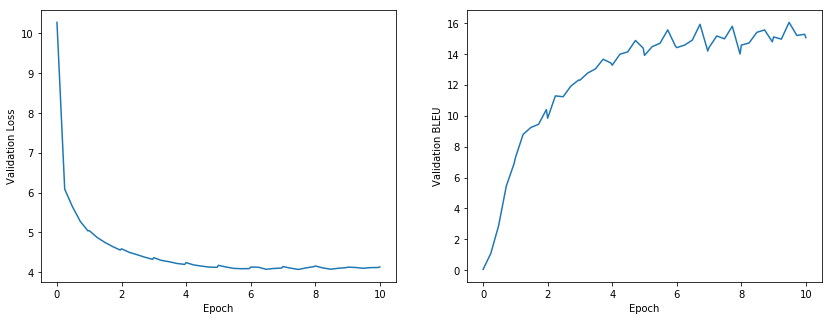

In [11]:
plot_single_learning_curve(experiment_results[0]['results'])

In [17]:
summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                       'total_params', 'trainable_params', 'dt_created']].head(1)

,model_name,best_val_loss,best_val_bleu,runtime,total_params,trainable_params,dt_created
0,vi-rnn-additive-attn-2018-12-12 19:04:50,4.067476,16.03673,372.135028,71591344.0,53591344.0,2018-12-13 01:17:03


In [18]:
# reload model 
MODEL_NAME_TO_RELOAD = 'vi-rnn-additive-attn-2018-12-12 19:04:50'
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME_TO_RELOAD), map_location=device)
model.load_state_dict(checkpoint)

In [19]:
# check performance on validation set 
val_loss, val_bleu, val_hyp_idxs, val_ref_idxs, val_source_idxs, val_hyp_tokens, val_ref_tokens, val_source_tokens,\
val_attn = evaluate(model=model, loader=loaders_full['dev'], 
                    src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Validation BLEU: {:.2f} | Validation Loss: {:.2f}".format(val_bleu, val_loss))

Validation BLEU: 16.04 | Validation Loss: 4.10


In [20]:
# evaluate on test set 
test_loss, test_bleu, test_hyp_idxs, test_ref_idxs, test_source_idxs, test_hyp_tokens, test_ref_tokens, test_source_tokens,\
test_attn = evaluate(model=model, loader=loaders_full['test'], 
                     src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Test BLEU: {:.2f} | Test Loss: {:.2f}".format(test_bleu, test_loss))

Test BLEU: 16.37 | Test Loss: 4.10
